<h1><center><font color = 'blue'>AMSUA N18 CH14 - Exploratory Data Analysis</font></center></h1>

In [1]:
import matplotlib.pyplot as plt
import lightgbm as lgbm
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from scipy import stats

### Import

In [2]:
df = pd.read_hdf('Data/amsua12_n18_ch14.h5')

### Compute Sensitivity sign

In [3]:
df['SENSITIVITY'] = np.sign(df['IMPACT']/df['OMF'])
df['SENSITIVITY'].value_counts()

 1.0    729048
-1.0    717956
Name: SENSITIVITY, dtype: int64

### Split inputs and outputs

In [4]:
X = df.drop(['DATETIME', 'IMPACT', 'OMF', 'SENSITIVITY'], axis=1)
y = df['SENSITIVITY']

cols_2D = [col for col in X.columns if not any(char.isdigit() for char in col)]

### Train and predict (Logistic Regression & Gradient Boosting)

In [5]:
# split train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [6]:
# train Logistic Regression
lr = LogisticRegression()
lr.fit(X_train[cols_2D], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [7]:
# train Gradient Boosting
gbm = lgbm.LGBMClassifier(objective='binary', n_estimators=300, learning_rate=0.1, random_state=10)

gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_names=('train', 'test'),
    eval_metric='logloss',
    early_stopping_rounds=20,
    feature_name=X_train.columns.tolist(),
    verbose=False
)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=300,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=10,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [8]:
# predict LR
lr_pred = lr.predict(X_test[cols_2D])

In [9]:
# predict GBM
gbm_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

/Users/gbolmier/anaconda3/envs/py3k/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Results

#### Linear Regression

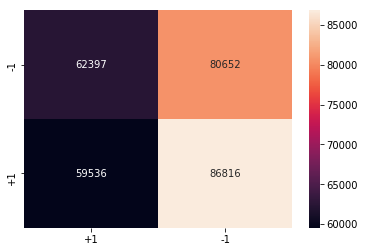

In [10]:
df_cm = pd.DataFrame(confusion_matrix(y_test, lr_pred),
                     index=['-1', '+1'], columns=['+1', '-1'])

heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

#### Gradient Boosting

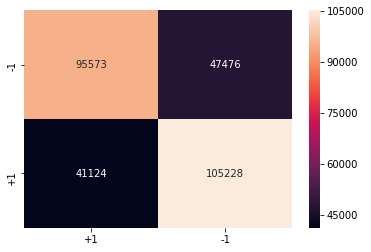

In [11]:
df_cm = pd.DataFrame(confusion_matrix(y_test, gbm_pred),
                     index=['-1', '+1'], columns=['+1', '-1'])

heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

#### Accuracy and f1 score

In [12]:
print('AMSUA LR Accuracy score:   {0:.4g}' .format(accuracy_score(y_test, lr_pred)))
print('AMSUA LR f1 score:         {0:.4g}' .format(f1_score(y_test, lr_pred)))
print('\n')
print('AMSUA GBM Accuracy score:  {0:.4g}' .format(accuracy_score(y_test, gbm_pred)))
print('AMSUA GBM f1 score:        {0:.4g}' .format(f1_score(y_test, gbm_pred)))

AMSUA LR Accuracy score:   0.5156
AMSUA LR f1 score:         0.5533


AMSUA GBM Accuracy score:  0.6939
AMSUA GBM f1 score:        0.7037
